In [18]:
EPS = 0
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def distance(self, other):
    return ((self.x - other.x)**2 + (self.y - other.y)**2)

  def __eq__(self, other):
    return self.distance(other) <= EPS

  def __hash__(self):
    return hash((round(self.x,5),round(self.x,5)))

  def __repr__(self):
    return f"({self.x}, {self.y})"


class Edge:
  def __init__(self, p1, p2):
    self.p1 = p1
    self.p2 = p2

  def __eq__(self, other):
    if not isinstance(other, Edge):
            return False
    return (self.p1 == other.p1 and self.p2 == other.p2 or self.p1==other.p2 and self.p2==other.p1)
  
  def __hash__(self):
    s = hash(self.p1)
    b = hash(self.p2)
    return hash((min(s,b),max(s,b)))

  def __repr__(self):
    return f"Edge({self.p1}, {self.p2})"
  


def orient(a,b,c):
    return (b.x-a.x)*(c.y-a.y)-(c.x-a.x)*(b.y-a.y)
#CCW > 0


class Triangle:
  def __init__(self, p1, p2, p3):

    if orient(p1,p2,p3) < 0:
      self.p1 = p1
      self.p2 = p3
      self.p3 = p2
    else:
      self.p1 = p1
      self.p2 = p2
      self.p3 = p3

    self.edges = [Edge(self.p1, self.p2), Edge(self.p2, self.p3), Edge(self.p3, self.p1)]
    self.neighbours = [None,None,None]
    self.is_bad = False

  def is_inside(self, p):
    return (    orient(self.p1, self.p2, p) >=0
            and orient(self.p2, self.p3, p) >=0
            and orient(self.p3, self.p1, p) >=0)
  
  def is_in_circumcircle(self, p):
    px, py = p.x, p.y
    p1x, p1y = self.p1.x, self.p1.y
    p2x, p2y = self.p2.x, self.p2.y
    p3x, p3y = self.p3.x, self.p3.y

    ax_ = p1x - px
    ay_ = p1y - py
    bx_ = p2x - px
    by_ = p2y - py
    cx_ = p3x - px
    cy_ = p3y - py

    det_a = ax_ * ax_ + ay_ * ay_
    det_b = bx_ * bx_ + by_ * by_
    det_c = cx_ * cx_ + cy_ * cy_

    det = (ax_ * (by_ * det_c - det_b * cy_) -
           ay_ * (bx_ * det_c - det_b * cx_) +
           det_a * (bx_ * cy_ - by_ * cx_))

    return det > EPS

  def __repr__(self):
    return f"Triangle({self.p1}, {self.p2}, {self.p3})"

  def __eq__(self, other):
      if not isinstance(other, Triangle):
          return False
      vertices_self = {self.p1, self.p2, self.p3}
      vertices_other = {other.p1, other.p2, other.p3}
      return vertices_self == vertices_other

  def __hash__(self):
      return hash(self.p1) ^ hash(self.p2) ^ hash(self.p3)


def SuperTriangle(P):
  """
  P to chmura punktów [Point(x1,y1),Point(x2,y2)...]
  """
  maxX = -float('inf')
  minX = float('inf')
  maxY = -float('inf')
  minY = float('inf')
  for p in P:
    x = p.x
    y = p.y
    if x > maxX:
      maxX = x
    if x < minX:
      minX = x
    if y > maxY:
      maxY = y
    if y < minY:
      minY = y

  dx = maxX - minX
  dy = maxY - minY
  delta = max(dx, dy)
  if delta == 0: delta = 1

  p1 = Point((minX + maxX) / 2, maxY + 20 * delta)
  p2 = Point(minX - 20 * delta, minY - delta)
  p3 = Point(maxX + 20 * delta, minY - delta)

  return Triangle(p1, p2, p3)



def is_outside(edge, p, triangle):
    # Prosty test znaku pola (orientacji)
    # Zwraca True, jeśli punkt p leży po prawej stronie krawędzi (edge.p1 -> edge.p2)
    # przy założeniu, że wnętrze trójkąta jest po lewej.
    val = (edge.p2.y - edge.p1.y) * (p.x - edge.p2.x) - \
          (edge.p2.x - edge.p1.x) * (p.y - edge.p2.y)
    return val > 0 # Jeśli dodatnie, punkt jest "na zewnątrz"




# --- NOWA FUNKCJA POMOCNICZA (CORE LOGIC) ---
def add_point_to_triangulation(triangulation, p, start_triangle):
    removed = set()
    visited_dfs = set()

    # 1. DFS - szukamy trójkątów do usunięcia (nielegalnych)
    def dfs(t):
        visited_dfs.add(t)
        if t.is_in_circumcircle(p):
            removed.add(t)
            for n in t.neighbours:
                if n is not None and n not in visited_dfs:
                    dfs(n)
    
    dfs(start_triangle)

    # 2. Znajdowanie boundary (granicy wnęki)
    boundary = {} # Krawędź -> Zewnętrzny Sąsiad
    
    for t in removed:
        for i, edge in enumerate(t.edges):
            neighbor = t.neighbours[i]
            # Jeśli sąsiada nie ma w 'removed', to jest to krawędź graniczna
            if neighbor not in removed:
                boundary[edge] = neighbor

    # 3. Usuwanie starych trójkątów
    for t in removed:
        triangulation.remove(t)

    # 4. Tworzenie nowych trójkątów i łączenie z zewnętrzem
    new_triangles = []
    
    for edge, outer_neighbor in boundary.items():
        # Tworzymy nowy trójkąt łączący krawędź graniczną z nowym punktem P
        newT = Triangle(edge.p1, edge.p2, p)
        new_triangles.append(newT)
        triangulation.add(newT)

        # Łączenie z ZEWNĘTRZNYM (starym) sąsiadem
        # Musimy znaleźć, która krawędź w nowym trójkącie to 'edge'
        for i, e_new in enumerate(newT.edges):
            if e_new == edge:
                newT.neighbours[i] = outer_neighbor
                
                # Aktualizacja wskazania w starym sąsiedzie
                if outer_neighbor:
                    for j, e_old in enumerate(outer_neighbor.edges):
                        if e_old == edge:
                            outer_neighbor.neighbours[j] = newT
                            break
                break

    # 5. Łączenie NOWYCH trójkątów między sobą
    # Krawędzie wychodzące z punktu P są wspólne dla nowych trójkątów
    shared_edges = {}
    
    for t in new_triangles:
        for i, e in enumerate(t.edges):
            # Pomijamy krawędzie graniczne (już połączone z boundary)
            if e in boundary: continue

            if e in shared_edges:
                other = shared_edges[e]
                # Łączymy t i other
                t.neighbours[i] = other
                
                # Znajdź indeks w 'other'
                for j, e_other in enumerate(other.edges):
                    if e_other == e:
                        other.neighbours[j] = t
                        break
            else:
                shared_edges[e] = t
    
    return new_triangles # Zwracamy listę nowych trójkątów


def clean_super_triangle(triangulation, st):
    # Tworzymy zbiór wierzchołków super-trójkąta dla szybkiego sprawdzania
    super_verts = {st.p1, st.p2, st.p3}
    toRemove = set()
    
    for t in triangulation:
        if t.p1 in super_verts or t.p2 in super_verts or t.p3 in super_verts:
            toRemove.add(t)
            
    # Czyścimy referencje sąsiadów w pozostawionych trójkątach 
    # (żeby nie wskazywały na usunięte), choć w Pythoie GC to załatwi, 
    # dla czystości topologicznej można by ustawić na None.
    
    return triangulation.difference(toRemove)


# --- METODA 1: NAIVE SEARCH ---
def naiveSearch(points):
    triangulation = set()
    st = SuperTriangle(points)
    triangulation.add(st)

    for p in points:
        start_triangle = None
        # Proste przeszukiwanie liniowe
        for t in triangulation:
            if t.is_inside(p):
                start_triangle = t
                break
        
        # Jeśli z jakiegoś powodu (błędy numeryczne) nie znaleziono, 
        # można spróbować przeszukać ponownie z większym marginesem, 
        # ale w idealnym przypadku zawsze się znajdzie (dzięki SuperTriangle)
        
        if start_triangle:
            add_point_to_triangulation(triangulation, p, start_triangle)

    return clean_super_triangle(triangulation, st)


# --- METODA 2: WALKING SEARCH ---
def walkingSearch(points):
    triangulation = set()
    st = SuperTriangle(points)
    triangulation.add(st)
    
    last_found = st

    for p in points:
        curr = last_found
        visited_walk = set()
        found_triangle = None
        
        # Algorytm spaceru
        while curr is not None:
            if curr in visited_walk:
                # Zapętlenie (rzadkie, ale możliwe przy błędach numerycznych).
                # Fallback do metody naiwnej.
                for t in triangulation:
                    if t.is_inside(p):
                        found_triangle = t
                        break
                break
            
            visited_walk.add(curr)
            
            if curr.is_inside(p):
                found_triangle = curr
                break
            
            # Decyzja nawigacyjna: przez którą krawędź przejść?
            moved = False
            for i, edge in enumerate(curr.edges):
                if is_outside(edge, p, curr):
                    next_tri = curr.neighbours[i]
                    if next_tri is not None:
                        curr = next_tri
                        moved = True
                        break
            
            if not moved:
                # Punkt jest na zewnątrz obecnego trójkąta, ale nie ma sąsiada w tym kierunku.
                # Może się zdarzyć na granicy SuperTriangle lub przy błędach numerycznych.
                # Fallback.
                for t in triangulation:
                    if t.is_inside(p):
                        found_triangle = t
                        break
                break

        if found_triangle:
            new_tris = add_point_to_triangulation(triangulation, p, found_triangle)
            if new_tris:
                # Optymalizacja: następny punkt prawdopodobnie będzie blisko tego
                last_found = new_tris[0]
    return clean_super_triangle(triangulation, st)

In [19]:
%pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt
ns = []
ws = []
ys = []
for i,n in enumerate([100,200,300,400,800,1600,3200,6600,7800,10000,20000]):
    Points = [Point(np.random.uniform(-100*(i+1),100*(i+1)),np.random.uniform(-100*(i+1),100*(i+1))) for _ in range(n)]
    start = time.perf_counter()
    r1=naiveSearch(Points)
    end = time.perf_counter()
    ns.append(end-start)

    start = time.perf_counter()
    r2 = walkingSearch(Points)
    end = time.perf_counter()
    ws.append(end-start)
    ys.append(n)

    print(r1 == r2)

True
True
True
True
True


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

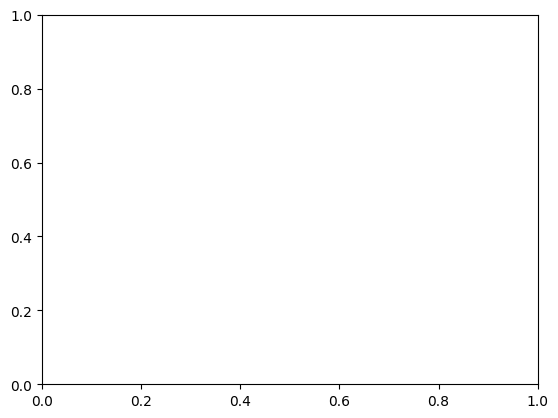

In [ ]:

plt.plot(ys,ns, c = 'red')
plt.plot(ys,ws, c='blue')
plt.xlabel('n')
plt.ylabel('t[ms]')
plt.show()

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np

# --- SYSTEM REJESTRACJI HISTORII ---
HISTORY = []

def record_state(triangulation, active_point, highlight_tris, color, title):
    snapshot = {
        'tris': list(triangulation),       
        'point': active_point,             
        'high_tris': list(highlight_tris) if highlight_tris else [],
        'color': color,
        'title': title
    }
    HISTORY.append(snapshot)

# --- ALGORYTMY (BEZ ZMIAN LOGIKI) ---
def add_point_to_triangulation(triangulation, p, start_triangle):
    removed = set()
    visited_dfs = set()
    
    def dfs(t):
        visited_dfs.add(t)
        if t.is_in_circumcircle(p):
            removed.add(t)
            for n in t.neighbours:
                if n and n not in visited_dfs: dfs(n)
    dfs(start_triangle)

    record_state(triangulation, p, removed, 'red', "Usuwanie wneki")

    boundary = {}
    for t in removed:
        for i, edge in enumerate(t.edges):
            if t.neighbours[i] not in removed: boundary[edge] = t.neighbours[i]
    
    for t in removed: triangulation.remove(t)

    new_triangles = []
    for edge, outer in boundary.items():
        newT = Triangle(edge.p1, edge.p2, p)
        new_triangles.append(newT)
        triangulation.add(newT)
        for i, e in enumerate(newT.edges):
            if e == edge:
                newT.neighbours[i] = outer
                if outer:
                    for j, oe in enumerate(outer.edges):
                        if oe == edge: outer.neighbours[j] = newT; break
                break
    
    shared_edges = {}
    for t in new_triangles:
        for i, e in enumerate(t.edges):
            if e in boundary: continue
            if e in shared_edges:
                other = shared_edges[e]
                t.neighbours[i] = other
                for j, oe in enumerate(other.edges):
                    if oe == e: other.neighbours[j] = t; break
            else: shared_edges[e] = t

    record_state(triangulation, p, new_triangles, 'blue', "Wstawianie nowych")
    return new_triangles

def walkingSearch(points):
    HISTORY.clear()
    triangulation = set()
    st = SuperTriangle(points)
    triangulation.add(st)
    last_found = st

    for i, p in enumerate(points):
        curr = last_found
        visited, found = set(), None
        path = [] 

        while curr:
            path.append(curr)
            if len(path) % 2 == 1:
                record_state(triangulation, p, path, 'orange', f"Walking Search ({i+1}/{len(points)})")

            if curr in visited:
                for t in triangulation:
                    if t.is_inside(p): found = t; break
                break
            visited.add(curr)

            if curr.is_inside(p): found = curr; break
            
            moved = False
            for idx, edge in enumerate(curr.edges):
                if is_outside(edge, p, curr):
                    if curr.neighbours[idx]: curr = curr.neighbours[idx]; moved = True; break
            if not moved:
                 for t in triangulation:
                    if t.is_inside(p): found = t; break
                 break
        
        if found:
            record_state(triangulation, p, [found], 'green', "Start found")
            new_tris = add_point_to_triangulation(triangulation, p, found)
            if new_tris: last_found = new_tris[0]
    
    final_tris = clean_super_triangle(triangulation, st)
    record_state(final_tris, None, [], 'white', "Koniec")
    return final_tris

def naiveSearch(points):
    HISTORY.clear()
    triangulation = set()
    st = SuperTriangle(points)
    triangulation.add(st)

    for i, p in enumerate(points):
        found = None
        for t in triangulation:
            if t.is_inside(p): found = t; break
        
        if found:
            record_state(triangulation, p, [found], 'green', f"Naive Search ({i+1})")
            add_point_to_triangulation(triangulation, p, found)

    return clean_super_triangle(triangulation, st)

# --- POPRAWIONY RENDERER (SZTYWNY ZOOM) ---
def render_gif(original_points, filename="delaunay_fixed.gif", duration=150):
    if not HISTORY:
        print("Brak historii.")
        return

    print(f"Renderowanie {len(HISTORY)} klatek (Sztywny Zoom)...")
    
    # 1. Oblicz granice TYLKO dla punktów użytkownika (bez SuperTrójkąta)
    xs = [p.x for p in original_points]
    ys = [p.y for p in original_points]
    
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # Dodaj margines 10%
    pad_x = (max_x - min_x) * 0.1
    pad_y = (max_y - min_y) * 0.1
    if pad_x == 0: pad_x = 10
    if pad_y == 0: pad_y = 10
    
    # Ustal ostateczne granice widoku
    VIEW_X = (min_x - pad_x, max_x + pad_x)
    VIEW_Y = (min_y - pad_y, max_y + pad_y)

    frames = []
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i, snap in enumerate(HISTORY):
        ax.clear()
        ax.set_title(snap['title'])
        
        # WYMUSZENIE GRANIC (To jest kluczowe - nadpisuje autoskalowanie)
        ax.set_xlim(VIEW_X)
        ax.set_ylim(VIEW_Y)
        
        # Rysuj trójkąty
        for t in snap['tris']:
            # Rysujemy trójkąt tylko, jeśli choć jeden wierzchołek jest w widoku 
            # (opcjonalna optymalizacja, ale matplotlib sam to przytnie)
            xs_t = [t.p1.x, t.p2.x, t.p3.x, t.p1.x]
            ys_t = [t.p1.y, t.p2.y, t.p3.y, t.p1.y]
            ax.plot(xs_t, ys_t, 'k-', linewidth=0.5, alpha=0.3)
        
        # Podświetlenia
        for t in snap['high_tris']:
            xs_t = [t.p1.x, t.p2.x, t.p3.x, t.p1.x]
            ys_t = [t.p1.y, t.p2.y, t.p3.y, t.p1.y]
            ax.fill(xs_t, ys_t, color=snap['color'], alpha=0.4)
            ax.plot(xs_t, ys_t, color=snap['color'], linewidth=1.5)
        
        # Rysuj WSZYSTKIE punkty (żeby było widać kontekst)
        ax.plot(xs, ys, 'b.', markersize=3, alpha=0.5)

        # Punkt aktywny
        if snap['point']:
            ax.plot(snap['point'].x, snap['point'].y, 'ro', markersize=6)
            
        # Zrzut klatki
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=80)
        buf.seek(0)
        frames.append(Image.open(buf))
        
    plt.close(fig)

    if frames:
        frames[0].save(filename, save_all=True, append_images=frames[1:], optimize=True, duration=duration, loop=0)
        print(f"Zapisano: {filename}")

In [35]:
# Generowanie punktów (mały obszar, np. 0-100)
pts = [Point(np.random.uniform(0, 100), np.random.uniform(0, 100)) for _ in range(15)]

print("Obliczenia...")
naiveSearch(pts)

# TERAZ MUSISZ PRZEKAZAĆ 'pts' DO FUNKCJI RENDERUJĄCEJ:
render_gif(pts, "delaunay_fixed.gif")

from IPython.display import Image as IPImage
IPImage(url='delaunay_fixed.gif')

Obliczenia...
Renderowanie 45 klatek (Sztywny Zoom)...
Zapisano: delaunay_fixed.gif
